```{raw} jupyter
<div id="qe-notebook-header" align="right" style="text-align:right;">
        <a href="https://quantecon.org/" title="quantecon.org">
                <img style="width:250px;display:inline;" width="250px" src="https://assets.quantecon.org/img/qe-menubar-logo.svg" alt="QuantEcon">
        </a>
</div>
```

# {index}`Cake Eating VI: EGM with JAX <single: Cake Eating VI: EGM with JAX>`

```{contents} Contents
:depth: 2
```


## Overview

In this lecture, we'll implement the endogenous grid method (EGM) using JAX.

This lecture builds on {doc}`cake_eating_egm`, which introduced EGM using NumPy.

By converting to JAX, we can leverage fast linear algebra, hardware accelerators, and JIT compilation for improved performance.

We'll also use JAX's `vmap` function to fully vectorize the Coleman-Reffett operator.

Let's start with some standard imports:

In [1]:
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import quantecon as qe
from typing import NamedTuple

## Implementation

For details on the savings problem and the endogenous grid method (EGM), please see {doc}`cake_eating_egm`.

Here we focus on the JAX implementation of EGM.

We use the same setting as in {doc}`cake_eating_egm`:

* $u(c) = \ln c$,
* production is Cobb-Douglas, and
* the shocks are lognormal.

Here are the analytical solutions for comparison.

In [2]:
def v_star(x, α, β, μ):
    """
    True value function
    """
    c1 = jnp.log(1 - α * β) / (1 - β)
    c2 = (μ + α * jnp.log(α * β)) / (1 - α)
    c3 = 1 / (1 - β)
    c4 = 1 / (1 - α * β)
    return c1 + c2 * (c3 - c4) + c4 * jnp.log(x)

def σ_star(x, α, β):
    """
    True optimal policy
    """
    return (1 - α * β) * x

The `Model` class stores only the data (grids, shocks, and parameters).

Utility and production functions will be defined globally to work with JAX's JIT compiler.

In [3]:
class Model(NamedTuple):
    β: float              # discount factor
    μ: float              # shock location parameter
    s: float              # shock scale parameter
    s_grid: jnp.ndarray   # exogenous savings grid
    shocks: jnp.ndarray   # shock draws
    α: float              # production function parameter


def create_model(β: float = 0.96,
                 μ: float = 0.0,
                 s: float = 0.1,
                 grid_max: float = 4.0,
                 grid_size: int = 120,
                 shock_size: int = 250,
                 seed: int = 1234,
                 α: float = 0.4) -> Model:
    """
    Creates an instance of the cake eating model.
    """
    # Set up exogenous savings grid
    s_grid = jnp.linspace(1e-4, grid_max, grid_size)

    # Store shocks (with a seed, so results are reproducible)
    key = jax.random.PRNGKey(seed)
    shocks = jnp.exp(μ + s * jax.random.normal(key, shape=(shock_size,)))

    return Model(β=β, μ=μ, s=s, s_grid=s_grid, shocks=shocks, α=α)

Here's the Coleman-Reffett operator using EGM.

The key JAX feature here is `vmap`, which vectorizes the computation over the grid points.

In [4]:
def K(
        c_in: jnp.ndarray,  # Consumption values on the endogenous grid
        x_in: jnp.ndarray,  # Current endogenous grid
        model: Model        # Model specification
    ):
    """
    The Coleman-Reffett operator using EGM

    """

    # Simplify names
    β, α = model.β, model.α
    s_grid, shocks = model.s_grid, model.shocks

    # Linear interpolation of policy using endogenous grid
    σ = lambda x_val: jnp.interp(x_val, x_in, c_in)

    # Define function to compute consumption at a single grid point
    def compute_c(s):
        vals = u_prime(σ(f(s, α) * shocks)) * f_prime(s, α) * shocks
        return u_prime_inv(β * jnp.mean(vals))

    # Vectorize over grid using vmap
    compute_c_vectorized = jax.vmap(compute_c)
    c_out = compute_c_vectorized(s_grid)

    # Determine corresponding endogenous grid
    x_out = s_grid + c_out  # x_i = s_i + c_i

    return c_out, x_out

We define utility and production functions globally.

Note that `f` and `f_prime` take `α` as an explicit argument, allowing them to work with JAX's functional programming model.

In [5]:
# Define utility and production functions with derivatives
u = lambda c: jnp.log(c)
u_prime = lambda c: 1 / c
u_prime_inv = lambda x: 1 / x
f = lambda k, α: k**α
f_prime = lambda k, α: α * k**(α - 1)

Now we create a model instance.

In [6]:
model = create_model()
s_grid = model.s_grid

W1124 04:06:16.987378   14474 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.
W1124 04:06:16.999435   14251 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.


The solver uses JAX's `jax.lax.while_loop` for the iteration and is JIT-compiled for speed.

In [7]:
@jax.jit
def solve_model_time_iter(model: Model,
                          c_init: jnp.ndarray,
                          x_init: jnp.ndarray,
                          tol: float = 1e-5,
                          max_iter: int = 1000):
    """
    Solve the model using time iteration with EGM.
    """

    def condition(loop_state):
        i, c, x, error = loop_state
        return (error > tol) & (i < max_iter)

    def body(loop_state):
        i, c, x, error = loop_state
        c_new, x_new = K(c, x, model)
        error = jnp.max(jnp.abs(c_new - c))
        return i + 1, c_new, x_new, error

    # Initialize loop state
    initial_state = (0, c_init, x_init, tol + 1)

    # Run the loop
    i, c, x, error = jax.lax.while_loop(condition, body, initial_state)

    return c, x

We solve the model starting from an initial guess.

In [8]:
c_init = jnp.copy(s_grid)
x_init = s_grid + c_init
c, x = solve_model_time_iter(model, c_init, x_init)

Let's plot the resulting policy against the analytical solution.

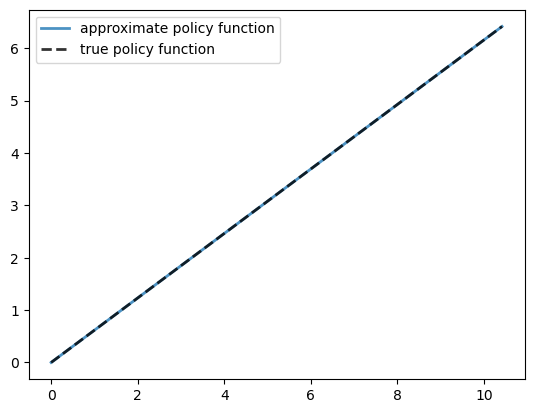

In [9]:
fig, ax = plt.subplots()

ax.plot(x, c, lw=2,
        alpha=0.8, label='approximate policy function')

ax.plot(x, σ_star(x, model.α, model.β), 'k--',
        lw=2, alpha=0.8, label='true policy function')

ax.legend()
plt.show()

The fit is very good.

In [10]:
max_dev = jnp.max(jnp.abs(c - σ_star(x, model.α, model.β)))
print(f"Maximum absolute deviation: {max_dev:.7}")

Maximum absolute deviation: 1.430511e-06


The JAX implementation is very fast thanks to JIT compilation and vectorization.

In [11]:
with qe.Timer(precision=8):
    c, x = solve_model_time_iter(model, c_init, x_init)
    jax.block_until_ready(c)

0.00706530 seconds elapsed


This speed comes from:

* JIT compilation of the entire solver
* Vectorization via `vmap` in the Coleman-Reffett operator
* Use of `jax.lax.while_loop` instead of a Python loop
* Efficient JAX array operations throughout

## Exercises

```{exercise}
:label: cake_egm_jax_ex1

Solve the stochastic cake eating problem with CRRA utility

$$
    u(c) = \frac{c^{1 - \gamma} - 1}{1 - \gamma}
$$

Compare the optimal policies for values of $\gamma$ approaching 1 from above (e.g., 1.05, 1.1, 1.2).

Show that as $\gamma \to 1$, the optimal policy converges to the policy obtained with log utility ($\gamma = 1$).

Hint: Use values of $\gamma$ close to 1 to ensure the endogenous grids have similar coverage and make visual comparison easier.
```

```{solution-start} cake_egm_jax_ex1
:class: dropdown
```

We need to create a version of the Coleman-Reffett operator and solver that work with CRRA utility.

The key is to parameterize the utility functions by $\gamma$.

In [12]:
def u_crra(c, γ):
    return (c**(1 - γ) - 1) / (1 - γ)

def u_prime_crra(c, γ):
    return c**(-γ)

def u_prime_inv_crra(x, γ):
    return x**(-1/γ)

Now we create a version of the Coleman-Reffett operator that takes $\gamma$ as a parameter.

In [13]:
def K_crra(
        c_in: jnp.ndarray,  # Consumption values on the endogenous grid
        x_in: jnp.ndarray,  # Current endogenous grid
        model: Model,       # Model specification
        γ: float            # CRRA parameter
    ):
    """
    The Coleman-Reffett operator using EGM with CRRA utility
    """
    # Simplify names
    β, α = model.β, model.α
    s_grid, shocks = model.s_grid, model.shocks

    # Linear interpolation of policy using endogenous grid
    σ = lambda x_val: jnp.interp(x_val, x_in, c_in)

    # Define function to compute consumption at a single grid point
    def compute_c(s):
        vals = u_prime_crra(σ(f(s, α) * shocks), γ) * f_prime(s, α) * shocks
        return u_prime_inv_crra(β * jnp.mean(vals), γ)

    # Vectorize over grid using vmap
    compute_c_vectorized = jax.vmap(compute_c)
    c_out = compute_c_vectorized(s_grid)

    # Determine corresponding endogenous grid
    x_out = s_grid + c_out  # x_i = s_i + c_i

    return c_out, x_out

We also need a solver that uses this operator.

In [14]:
@jax.jit
def solve_model_crra(model: Model,
                     c_init: jnp.ndarray,
                     x_init: jnp.ndarray,
                     γ: float,
                     tol: float = 1e-5,
                     max_iter: int = 1000):
    """
    Solve the model using time iteration with EGM and CRRA utility.
    """

    def condition(loop_state):
        i, c, x, error = loop_state
        return (error > tol) & (i < max_iter)

    def body(loop_state):
        i, c, x, error = loop_state
        c_new, x_new = K_crra(c, x, model, γ)
        error = jnp.max(jnp.abs(c_new - c))
        return i + 1, c_new, x_new, error

    # Initialize loop state
    initial_state = (0, c_init, x_init, tol + 1)

    # Run the loop
    i, c, x, error = jax.lax.while_loop(condition, body, initial_state)

    return c, x

Now we solve for $\gamma = 1$ (log utility) and values approaching 1 from above.

In [15]:
γ_values = [1.0, 1.05, 1.1, 1.2]
policies = {}
endogenous_grids = {}

model_crra = create_model()

for γ in γ_values:
    c_init = jnp.copy(model_crra.s_grid)
    x_init = model_crra.s_grid + c_init
    c_gamma, x_gamma = solve_model_crra(model_crra, c_init, x_init, γ)
    jax.block_until_ready(c_gamma)
    policies[γ] = c_gamma
    endogenous_grids[γ] = x_gamma
    print(f"Solved for γ = {γ}")

Solved for γ = 1.0
Solved for γ = 1.05
Solved for γ = 1.1
Solved for γ = 1.2


Plot the policies on their endogenous grids.

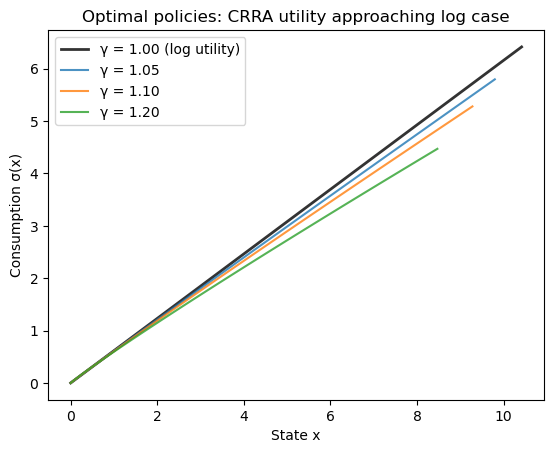

In [16]:
fig, ax = plt.subplots()

for γ in γ_values:
    x = endogenous_grids[γ]
    if γ == 1.0:
        ax.plot(x, policies[γ], 'k-', linewidth=2,
                label=f'γ = {γ:.2f} (log utility)', alpha=0.8)
    else:
        ax.plot(x, policies[γ], label=f'γ = {γ:.2f}', alpha=0.8)

ax.set_xlabel('State x')
ax.set_ylabel('Consumption σ(x)')
ax.legend()
ax.set_title('Optimal policies: CRRA utility approaching log case')
plt.show()

Note that the plots for $\gamma > 1$ do not cover the entire x-axis range shown.

This is because the endogenous grid $x = s + \sigma(s)$ depends on the consumption policy, which varies with $\gamma$.

Let's check the maximum deviation between the log utility case ($\gamma = 1.0$) and values approaching from above.

In [17]:
for γ in [1.05, 1.1, 1.2]:
    max_diff = jnp.max(jnp.abs(policies[1.0] - policies[γ]))
    print(f"Max difference between γ=1.0 and γ={γ}: {max_diff:.6}")

Max difference between γ=1.0 and γ=1.05: 0.619199
Max difference between γ=1.0 and γ=1.1: 1.1362
Max difference between γ=1.0 and γ=1.2: 1.94592


As expected, the differences decrease as $\gamma$ approaches 1 from above, confirming convergence.

```{solution-end}
```